In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


Evaluating for dataset size: 1000
Epoch 0 - Loss: 1.5893158912658691
Epoch 100 - Loss: 0.12666821479797363
Epoch 200 - Loss: 0.12573038041591644
Epoch 300 - Loss: 0.12545058131217957
Epoch 400 - Loss: 0.12532585859298706
Evaluating for dataset size: 5000
Epoch 0 - Loss: 1.6144590377807617
Epoch 100 - Loss: 0.13189929723739624
Epoch 200 - Loss: 0.13176044821739197
Early stopping at epoch 296 with best loss 0.1318
Evaluating for dataset size: 10000
Epoch 0 - Loss: 1.5035535097122192
Epoch 100 - Loss: 0.1317322850227356
Epoch 200 - Loss: 0.131711944937706
Early stopping at epoch 264 with best loss 0.1317


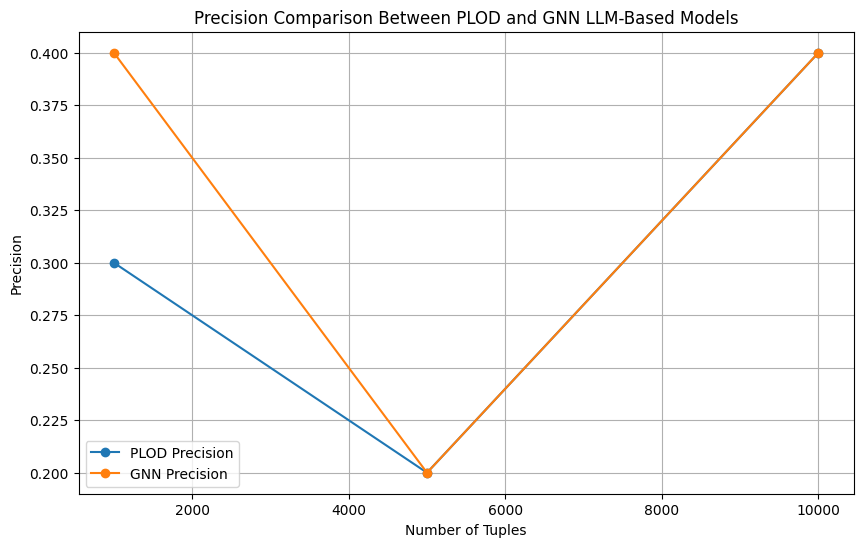

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from transformers import BertModel, BertTokenizer
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# LLM-based feature extraction model
class LLMFeatureExtractor(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(LLMFeatureExtractor, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name)

    def forward(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = self.bert(**inputs)
        return outputs.pooler_output

# GNN model for utility estimation
class GNNUtilityModel(nn.Module):
    def __init__(self, num_node_features):
        super(GNNUtilityModel, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        return x

# Create graph from housing data
def create_graph_from_housing_data(houses_df, llm_model):
    features_list = []
    for text in houses_df['combined_text']:
        features = llm_model(text).detach().numpy().squeeze()
        features_list.append(features)

    node_features = torch.tensor(np.array(features_list), dtype=torch.float)
    edge_index = torch.tensor([[i, i] for i in range(len(features_list))]).t().contiguous()
    return node_features, edge_index

# Integrate PLOD predictions into GNN features
def integrate_plod_into_gnn(node_features, plod_predictions):
    plod_features = torch.tensor(plod_predictions).unsqueeze(1).float()
    integrated_features = torch.cat([node_features, plod_features], dim=1)
    return integrated_features

# Implement PLOD
def run_plod(X_train, X_test, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test), model.predict(pd.concat([X_train, X_test], axis=0))

# Evaluate models
def evaluate_models(num_rows):
    # Step 1: Create the dataset
    combined_data = pd.DataFrame({
        'size': np.random.rand(num_rows),
        'age': np.random.rand(num_rows),
        'style': np.random.rand(num_rows),
        'number_of_bedrooms': np.random.rand(num_rows),
        'number_of_bathrooms': np.random.rand(num_rows)
    })

    combined_text_features = [
        "within walking distance to a school near a small park and close to work",
        "far from any school within a short drive to a large park",
        "directly next to a top-rated school next to a beautiful park and close to work",
        "within walking distance to a school next to a park and close to shopping",
        "close to the hospital and near a large entertainment complex",
        "located in a quiet neighborhood with easy access to public transportation",
        "in a bustling urban area with many nearby amenities and entertainment options",
        "nestled in a serene area with proximity to nature and hiking trails",
        "in a newly developed residential area with modern facilities",
        "close to major highways and transit routes, offering convenience for commuting"
    ] * (num_rows // 10)

    combined_data['combined_text'] = combined_text_features

    scaler = MinMaxScaler()
    combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data.drop(columns=['combined_text'])),
                                        columns=combined_data.columns[:-1])

    housing_prices = (
        0.6 * combined_data_scaled['size'] +
        0.4 * combined_data_scaled['age'] +
        0.5 * combined_data_scaled['style'] +
        0.4 * combined_data_scaled['number_of_bedrooms'] +
        0.4 * combined_data_scaled['number_of_bathrooms'] +
        np.random.normal(scale=0.2, size=num_rows)
    )

    X_train, X_test, y_train, y_test = train_test_split(combined_data_scaled, housing_prices, test_size=0.5, random_state=42)

    # Step 2: PLOD model predictions
    plod_predictions_test, plod_predictions_all = run_plod(X_train, X_test, y_train)

    # Step 3: GNN model
    llm_model = LLMFeatureExtractor()
    node_features, edge_index = create_graph_from_housing_data(combined_data, llm_model)
    integrated_features = integrate_plod_into_gnn(node_features, plod_predictions_all)
    gnn_model = GNNUtilityModel(num_node_features=integrated_features.shape[1])
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training GNN
    best_loss = float('inf')
    early_stopping_threshold = 100
    early_stopping_counter = 0

    for epoch in range(500):
        gnn_model.train()
        optimizer.zero_grad()
        output = gnn_model(integrated_features, edge_index)
        loss = criterion(output.squeeze(), torch.tensor(housing_prices, dtype=torch.float))
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_threshold:
            print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
            break

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item()}")

    # Predict using GNN
    gnn_model.eval()
    gnn_predictions = gnn_model(integrated_features, edge_index).squeeze().detach().numpy()

    housing_prices_gnn = (
        0.6 * combined_data_scaled['size'] +
        0.4 * combined_data_scaled['age'] +
        0.5 * combined_data_scaled['style'] +
        0.4 * combined_data_scaled['number_of_bedrooms'] +
        0.4 * combined_data_scaled['number_of_bathrooms'] +
        gnn_predictions
    )

    def calculate_precision(y_true, y_pred, top_k=10):
        true_top_k = np.argsort(y_true)[-top_k:]
        pred_top_k = np.argsort(y_pred)[-top_k:]
        return len(set(true_top_k).intersection(set(pred_top_k))) / top_k

    plod_precision = calculate_precision(y_test, plod_predictions_test)
    gnn_precision = calculate_precision(y_test, housing_prices_gnn[X_test.index])

    return plod_precision, gnn_precision

# Step 4: Run the evaluation for different dataset sizes
dataset_sizes = [1000, 5000, 10000]
plod_precisions = []
gnn_precisions = []

for size in dataset_sizes:
    print(f"Evaluating for dataset size: {size}")
    plod_prec, gnn_prec = evaluate_models(size)
    plod_precisions.append(plod_prec)
    gnn_precisions.append(gnn_prec)

# Step 5: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, plod_precisions, marker='o', label='PLOD Precision')
plt.plot(dataset_sizes, gnn_precisions, marker='o', label='GNN Precision')
plt.xlabel('Number of Tuples')
plt.ylabel('Precision')
plt.title('Precision Comparison Between PLOD and GNN LLM-Based Models')
plt.legend()
plt.grid(True)
plt.show()


Evaluating for dataset size: 2500
Epoch 0 - Loss: 1.4847040176391602
Epoch 100 - Loss: 0.11966057121753693
Epoch 200 - Loss: 0.1190343052148819
Epoch 300 - Loss: 0.11886468529701233
Epoch 400 - Loss: 0.118782177567482
Evaluating for dataset size: 5000
Epoch 0 - Loss: 1.4912256002426147
Epoch 100 - Loss: 0.12277781963348389
Epoch 200 - Loss: 0.12257780879735947
Epoch 300 - Loss: 0.12257779389619827
Early stopping at epoch 343 with best loss 0.1226
Evaluating for dataset size: 7500
Epoch 0 - Loss: 1.389630913734436
Epoch 100 - Loss: 0.12478601187467575
Epoch 200 - Loss: 0.12473074346780777
Early stopping at epoch 299 with best loss 0.1247
Evaluating for dataset size: 10000
Epoch 0 - Loss: 1.213043212890625
Epoch 100 - Loss: 0.12544450163841248
Epoch 200 - Loss: 0.12543101608753204
Epoch 300 - Loss: 0.12543100118637085
Early stopping at epoch 340 with best loss 0.1254


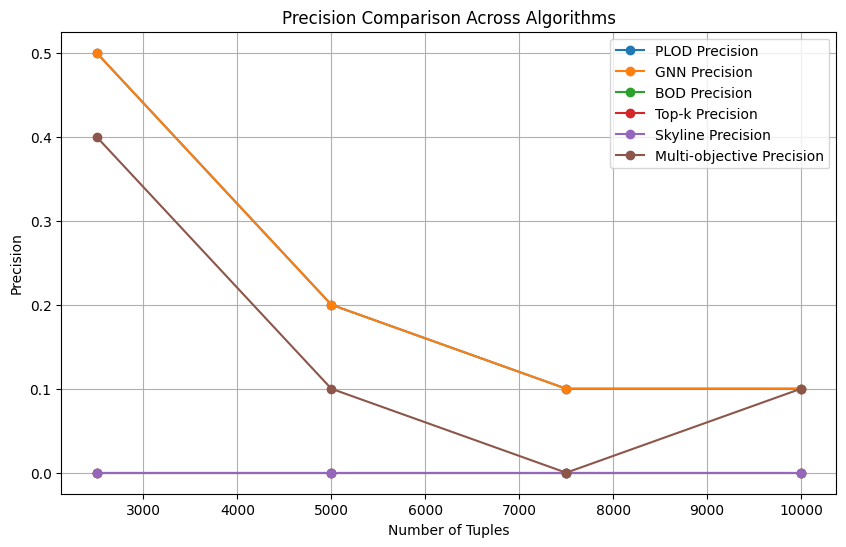

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from transformers import BertModel, BertTokenizer
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# LLM-based feature extraction model
class LLMFeatureExtractor(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(LLMFeatureExtractor, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name)

    def forward(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = self.bert(**inputs)
        return outputs.pooler_output

# GNN model for utility estimation
class GNNUtilityModel(nn.Module):
    def __init__(self, num_node_features):
        super(GNNUtilityModel, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        return x

# Create graph from housing data
def create_graph_from_housing_data(houses_df, llm_model):
    features_list = []
    for text in houses_df['combined_text']:
        features = llm_model(text).detach().numpy().squeeze()
        features_list.append(features)

    node_features = torch.tensor(np.array(features_list), dtype=torch.float)
    edge_index = torch.tensor([[i, i] for i in range(len(features_list))]).t().contiguous()
    return node_features, edge_index

# Integrate PLOD predictions into GNN features
def integrate_plod_into_gnn(node_features, plod_predictions):
    plod_features = torch.tensor(plod_predictions).unsqueeze(1).float()
    integrated_features = torch.cat([node_features, plod_features], dim=1)
    return integrated_features

# Implement PLOD
def run_plod(X_train, X_test, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test), model.predict(pd.concat([X_train, X_test], axis=0))

# Implement BOD (Business-Oriented Decision Making) with three rounds of filtering
def run_bod_three_rounds(X_test):
    selected_columns_1 = X_test[['size', 'style', 'number_of_bedrooms']]
    max_row_sum_1 = selected_columns_1.sum(axis=1).max()
    max_sum_index_1 = selected_columns_1.sum(axis=1).idxmax()
    y_min_1 = max_row_sum_1
    y_max_1 = X_test.loc[max_sum_index_1].sum()

    sum_all_rows_1 = X_test.sum(axis=1)
    return_sum_list_1 = [i for i in sum_all_rows_1 if y_min_1 <= i <= y_max_1]
    return_index_list_1 = [idx for idx, i in enumerate(X_test.sum(axis=1)) if i in return_sum_list_1]
    distinct_values_1 = list(set(return_index_list_1))

    filter_1st_dataframe = X_test.iloc[distinct_values_1].copy()

    selected_columns_2 = filter_1st_dataframe[['size', 'style', 'number_of_bedrooms', 'number_of_bathrooms']]
    max_row_sum_2 = selected_columns_2.sum(axis=1).max()
    max_sum_index_2 = selected_columns_2.sum(axis=1).idxmax()
    y_min_2 = max_row_sum_2
    y_max_2 = filter_1st_dataframe.loc[max_sum_index_2].sum()

    sum_all_rows_2 = filter_1st_dataframe.sum(axis=1)
    return_sum_list_2 = [i for i in sum_all_rows_2 if y_min_2 <= i <= y_max_2]
    return_index_list_2 = [idx for idx, i in enumerate(filter_1st_dataframe.sum(axis=1)) if i in return_sum_list_2]
    distinct_values_2 = list(set(return_index_list_2))

    filter_2nd_theFinal_dataframe = filter_1st_dataframe.iloc[distinct_values_2].copy()

    selected_columns_3 = filter_2nd_theFinal_dataframe
    max_row_sum_3 = selected_columns_3.sum(axis=1).max()
    max_sum_index_3 = selected_columns_3.sum(axis=1).idxmax()
    y_min_3 = max_row_sum_3
    y_max_3 = filter_2nd_theFinal_dataframe.loc[max_sum_index_3].sum()

    sum_all_rows_3 = filter_2nd_theFinal_dataframe.sum(axis=1)
    return_sum_list_3 = [i for i in sum_all_rows_3 if y_min_3 <= i <= y_max_3]
    return_index_list_3 = [idx for idx, i in enumerate(filter_2nd_theFinal_dataframe.sum(axis=1)) if i in return_sum_list_3]
    distinct_values_3 = list(set(return_index_list_3))

    return filter_2nd_theFinal_dataframe.iloc[distinct_values_3].sum(axis=1)

# Implement Top-k Query Processing
def run_top_k(X_test, k=10):
    scores = X_test.sum(axis=1)
    top_k_indices = scores.nlargest(k).index
    return X_test.loc[top_k_indices].sum(axis=1)

# Implement Skyline Query (Pareto front)
def run_skyline(X_test):
    pareto_mask = np.ones(X_test.shape[0], dtype=bool)
    for i, c in enumerate(X_test.values):
        if pareto_mask[i]:
            pareto_mask[pareto_mask] = np.any(X_test[pareto_mask] > c, axis=1)
            pareto_mask[i] = True
    return X_test[pareto_mask].sum(axis=1)

# Implement Multi-objective Optimization (Weighted Sum)
def run_multi_objective(X_test):
    weights = np.random.rand(X_test.shape[1])
    weighted_sum = X_test.dot(weights)
    return weighted_sum

# Evaluate models
def evaluate_models(num_rows):
    # Ensure that the number of rows is large enough to split
    if num_rows < 2:
        return None, None, None, None, None, None

    # Step 1: Create the dataset
    combined_data = pd.DataFrame({
        'size': np.random.rand(num_rows),
        'age': np.random.rand(num_rows),
        'style': np.random.rand(num_rows),
        'number_of_bedrooms': np.random.rand(num_rows),
        'number_of_bathrooms': np.random.rand(num_rows)
    })

    combined_text_features = [
        "within walking distance to a school near a small park and close to work",
        "far from any school within a short drive to a large park",
        "directly next to a top-rated school next to a beautiful park and close to work",
        "within walking distance to a school next to a park and close to shopping",
        "close to the hospital and near a large entertainment complex",
        "located in a quiet neighborhood with easy access to public transportation",
        "in a bustling urban area with many nearby amenities and entertainment options",
        "nestled in a serene area with proximity to nature and hiking trails",
        "in a newly developed residential area with modern facilities",
        "close to major highways and transit routes, offering convenience for commuting"
    ] * (num_rows // 10 + 1)  # Ensure we have enough text entries

    combined_data['combined_text'] = combined_text_features[:num_rows]

    scaler = MinMaxScaler()
    combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data.drop(columns=['combined_text'])),
                                        columns=combined_data.columns[:-1])

    housing_prices = (
        0.6 * combined_data_scaled['size'] +
        0.3 * combined_data_scaled['age'] +
        0.5 * combined_data_scaled['style'] +
        0.4 * combined_data_scaled['number_of_bedrooms'] +
        0.4 * combined_data_scaled['number_of_bathrooms'] +
        np.random.normal(scale=0.2, size=num_rows)
    )

    X_train, X_test, y_train, y_test = train_test_split(combined_data_scaled, housing_prices, test_size=0.5, random_state=42)

    # Step 2: PLOD model predictions
    plod_predictions_test, plod_predictions_all = run_plod(X_train, X_test, y_train)

    # BOD, Top-K, Skyline, and Multi-objective predictions
    bod_predictions = run_bod_three_rounds(X_test)
    top_k_predictions = run_top_k(X_test)
    skyline_predictions = run_skyline(X_test)
    multi_objective_predictions = run_multi_objective(X_test)

    # Step 3: GNN model
    llm_model = LLMFeatureExtractor()
    node_features, edge_index = create_graph_from_housing_data(combined_data, llm_model)
    integrated_features = integrate_plod_into_gnn(node_features, plod_predictions_all)
    gnn_model = GNNUtilityModel(num_node_features=integrated_features.shape[1])
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training GNN
    best_loss = float('inf')
    early_stopping_threshold = 100
    early_stopping_counter = 0

    for epoch in range(500):
        gnn_model.train()
        optimizer.zero_grad()
        output = gnn_model(integrated_features, edge_index)
        loss = criterion(output.squeeze(), torch.tensor(housing_prices, dtype=torch.float))
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_threshold:
            print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
            break

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item()}")

    # Predict using GNN
    gnn_model.eval()
    gnn_predictions = gnn_model(integrated_features, edge_index).squeeze().detach().numpy()

    housing_prices_gnn = (
        0.6 * combined_data_scaled['size'] +
        0.3 * combined_data_scaled['age'] +
        0.5 * combined_data_scaled['style'] +
        0.4 * combined_data_scaled['number_of_bedrooms'] +
        0.4 * combined_data_scaled['number_of_bathrooms'] +
        gnn_predictions
    )

    def calculate_precision(y_true, y_pred, top_k=10):
        true_top_k = np.argsort(y_true)[-top_k:]
        pred_top_k = np.argsort(y_pred)[-top_k:]
        return len(set(true_top_k).intersection(set(pred_top_k))) / top_k

    plod_precision = calculate_precision(y_test, plod_predictions_test)
    gnn_precision = calculate_precision(y_test, housing_prices_gnn[X_test.index])
    bod_precision = calculate_precision(y_test, bod_predictions)
    top_k_precision = calculate_precision(y_test, top_k_predictions)
    skyline_precision = calculate_precision(y_test, skyline_predictions)
    multi_objective_precision = calculate_precision(y_test, multi_objective_predictions)

    return plod_precision, gnn_precision, bod_precision, top_k_precision, skyline_precision, multi_objective_precision

# Step 4: Run the evaluation for different dataset sizes
dataset_sizes = range(2500, 10001, 2500)
plod_precisions = []
gnn_precisions = []
bod_precisions = []
top_k_precisions = []
skyline_precisions = []
multi_objective_precisions = []

for size in dataset_sizes:
    print(f"Evaluating for dataset size: {size}")
    plod_prec, gnn_prec, bod_prec, top_k_prec, skyline_prec, multi_objective_prec = evaluate_models(size)
    plod_precisions.append(plod_prec)
    gnn_precisions.append(gnn_prec)
    bod_precisions.append(bod_prec)
    top_k_precisions.append(top_k_prec)
    skyline_precisions.append(skyline_prec)
    multi_objective_precisions.append(multi_objective_prec)

# Step 5: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, plod_precisions, marker='o', label='PLOD Precision')
plt.plot(dataset_sizes, gnn_precisions, marker='o', label='GNN Precision')
plt.plot(dataset_sizes, bod_precisions, marker='o', label='BOD Precision')
plt.plot(dataset_sizes, top_k_precisions, marker='o', label='Top-k Precision')
plt.plot(dataset_sizes, skyline_precisions, marker='o', label='Skyline Precision')
plt.plot(dataset_sizes, multi_objective_precisions, marker='o', label='Multi-objective Precision')
plt.xlabel('Number of Tuples')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Algorithms')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Print precision scores for each algorithm
print("Precision scores across dataset sizes:")

print("\nPLOD Precision Scores:")
print(plod_precisions)

print("\nGNN Precision Scores:")
print(gnn_precisions)

print("\nBOD Precision Scores:")
print(bod_precisions)

print("\nTop-K Precision Scores:")
print(top_k_precisions)

print("\nSkyline Precision Scores:")
print(skyline_precisions)

print("\nMulti-objective Precision Scores:")
print(multi_objective_precisions)


Precision scores across dataset sizes:

PLOD Precision Scores:
[0.5, 0.2, 0.1, 0.1]

GNN Precision Scores:
[0.5, 0.2, 0.1, 0.1]

BOD Precision Scores:
[0.0, 0.0, 0.0, 0.0]

Top-K Precision Scores:
[0.0, 0.0, 0.0, 0.0]

Skyline Precision Scores:
[0.0, 0.0, 0.0, 0.0]

Multi-objective Precision Scores:
[0.4, 0.1, 0.0, 0.1]


Evaluating for dataset size: 2500
Epoch 0 - Loss: 1.4720689058303833
Epoch 100 - Loss: 0.12476813793182373
Epoch 200 - Loss: 0.12329128384590149
Epoch 300 - Loss: 0.12288816273212433
Epoch 400 - Loss: 0.12273702025413513
Epoch 0 - Loss: 1.135806918144226
Epoch 100 - Loss: 0.12629802525043488
Epoch 200 - Loss: 0.12629736959934235
Early stopping at epoch 285 with best loss 0.1263
Epoch 0 - Loss: 1.6364219188690186
Epoch 100 - Loss: 0.12607340514659882
Epoch 200 - Loss: 0.12514515221118927
Epoch 300 - Loss: 0.12463707476854324
Epoch 400 - Loss: 0.12440178543329239
Epoch 0 - Loss: 1.972044587135315
Epoch 100 - Loss: 0.1230354979634285
Epoch 200 - Loss: 0.12184976786375046
Epoch 300 - Loss: 0.12137099355459213
Epoch 400 - Loss: 0.12119775265455246
Epoch 0 - Loss: 1.4662915468215942
Epoch 100 - Loss: 0.1325719654560089
Epoch 200 - Loss: 0.12721215188503265
Epoch 300 - Loss: 0.12676364183425903
Epoch 400 - Loss: 0.12659238278865814
Epoch 0 - Loss: 1.484958529472351
Epoch 100 - Loss: 0.1235608

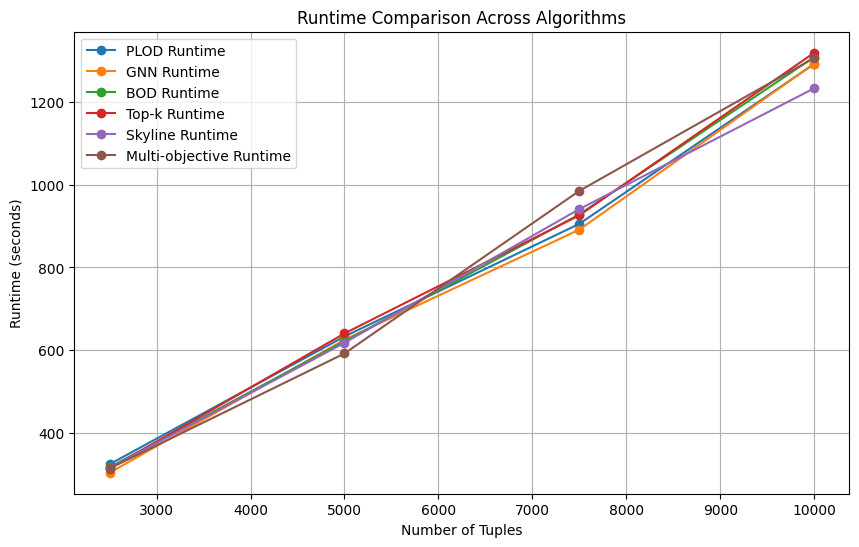

In [ ]:
import time
import matplotlib.pyplot as plt

# Lists to store runtime results
plod_runtimes = []
gnn_runtimes = []
bod_runtimes = []
top_k_runtimes = []
skyline_runtimes = []
multi_objective_runtimes = []

# Evaluate across all dataset sizes without steps
dataset_sizes = range(2500, 10001, 2500)

for size in dataset_sizes:
    print(f"Evaluating for dataset size: {size}")

    # Measure runtime for PLOD
    start_time = time.time()
    plod_prec, _, _, _, _, _ = evaluate_models(size)
    plod_runtimes.append(time.time() - start_time)

    # Measure runtime for GNN
    start_time = time.time()
    _, gnn_prec, _, _, _, _ = evaluate_models(size)
    gnn_runtimes.append(time.time() - start_time)

    # Measure runtime for BOD
    start_time = time.time()
    _, _, bod_prec, _, _, _ = evaluate_models(size)
    bod_runtimes.append(time.time() - start_time)

    # Measure runtime for Top-K
    start_time = time.time()
    _, _, _, top_k_prec, _, _ = evaluate_models(size)
    top_k_runtimes.append(time.time() - start_time)

    # Measure runtime for Skyline
    start_time = time.time()
    _, _, _, _, skyline_prec, _ = evaluate_models(size)
    skyline_runtimes.append(time.time() - start_time)

    # Measure runtime for Multi-objective
    start_time = time.time()
    _, _, _, _, _, multi_objective_prec = evaluate_models(size)
    multi_objective_runtimes.append(time.time() - start_time)

# Plot the runtime results
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, plod_runtimes, marker='o', label='PLOD Runtime')
plt.plot(dataset_sizes, gnn_runtimes, marker='o', label='GNN Runtime')
plt.plot(dataset_sizes, bod_runtimes, marker='o', label='BOD Runtime')
plt.plot(dataset_sizes, top_k_runtimes, marker='o', label='Top-k Runtime')
plt.plot(dataset_sizes, skyline_runtimes, marker='o', label='Skyline Runtime')
plt.plot(dataset_sizes, multi_objective_runtimes, marker='o', label='Multi-objective Runtime')
plt.xlabel('Number of Tuples')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison Across Algorithms')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = "Housing.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print("Original Data:")
print(df.head())

# Handling missing values
# Fill NA/NaN values with the column mean for numerical columns
df.fillna(df.mean(numeric_only=True), inplace=True)

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Normalize numerical data to be within the range [0, 1]
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Recombine the numerical and categorical data
df_final = pd.concat([df[numerical_cols], df[categorical_cols]], axis=1)

# Display the first few rows of the cleaned and normalized dataframe
print("\nCleaned and Normalized Data with Original Text Values:")
print(df_final.head())

# Save the cleaned and normalized dataset
df_final.to_csv("cleaned_normalized_housing_data_with_text.csv", index=False)


Original Data:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Cleaned and Normalized Data with Original Text Values:
      price      area  bedro

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# GNN model for utility estimation
class GNNUtilityModel(nn.Module):
    def __init__(self, num_node_features):
        super(GNNUtilityModel, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        return x

# Create graph from housing data
def create_graph_from_housing_data(houses_df):
    node_features = torch.tensor(houses_df.values, dtype=torch.float)
    edge_index = torch.tensor([[i, i] for i in range(len(houses_df))]).t().contiguous()
    return node_features, edge_index

# Integrate PLOD predictions into GNN features
def integrate_plod_into_gnn(node_features, plod_predictions):
    plod_features = torch.tensor(plod_predictions).unsqueeze(1).float()
    integrated_features = torch.cat([node_features, plod_features], dim=1)
    return integrated_features

# Implement PLOD
def run_plod(X_train, X_test, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test), model.predict(pd.concat([X_train, X_test], axis=0))

# Implement BOD (Business-Oriented Decision Making) with three rounds of filtering
def run_bod_three_rounds(X_test):
    selected_columns_1 = X_test[['area', 'bedrooms', 'bathrooms','stories','price']]
    max_row_sum_1 = selected_columns_1.sum(axis=1).max()
    max_sum_index_1 = selected_columns_1.sum(axis=1).idxmax()
    y_min_1 = max_row_sum_1
    y_max_1 = X_test.loc[max_sum_index_1].sum()

    sum_all_rows_1 = X_test.sum(axis=1)
    return_sum_list_1 = [i for i in sum_all_rows_1 if y_min_1 <= i <= y_max_1]
    return_index_list_1 = [idx for idx, i in enumerate(X_test.sum(axis=1)) if i in return_sum_list_1]
    distinct_values_1 = list(set(return_index_list_1))

    filter_1st_dataframe = X_test.iloc[distinct_values_1].copy()

    selected_columns_2 = filter_1st_dataframe[['area', 'bedrooms', 'bathrooms','stories','price', 'parking']]
    max_row_sum_2 = selected_columns_2.sum(axis=1).max()
    max_sum_index_2 = selected_columns_2.sum(axis=1).idxmax()
    y_min_2 = max_row_sum_2
    y_max_2 = filter_1st_dataframe.loc[max_sum_index_2].sum()

    sum_all_rows_2 = filter_1st_dataframe.sum(axis=1)
    return_sum_list_2 = [i for i in sum_all_rows_2 if y_min_2 <= i <= y_max_2]
    return_index_list_2 = [idx for idx, i in enumerate(filter_1st_dataframe.sum(axis=1)) if i in return_sum_list_2]
    distinct_values_2 = list(set(return_index_list_2))

    filter_2nd_theFinal_dataframe = filter_1st_dataframe.iloc[distinct_values_2].copy()

    selected_columns_3 = filter_2nd_theFinal_dataframe
    max_row_sum_3 = selected_columns_3.sum(axis=1).max()
    max_sum_index_3 = selected_columns_3.sum(axis=1).idxmax()
    y_min_3 = max_row_sum_3
    y_max_3 = filter_2nd_theFinal_dataframe.loc[max_sum_index_3].sum()

    sum_all_rows_3 = filter_2nd_theFinal_dataframe.sum(axis=1)
    return_sum_list_3 = [i for i in sum_all_rows_3 if y_min_3 <= i <= y_max_3]
    return_index_list_3 = [idx for idx, i in enumerate(filter_2nd_theFinal_dataframe.sum(axis=1)) if i in return_sum_list_3]
    distinct_values_3 = list(set(return_index_list_3))

    return filter_2nd_theFinal_dataframe.iloc[distinct_values_3].sum(axis=1)

# Implement Top-k Query Processing
def run_top_k(X_test, k=10):
    scores = X_test.sum(axis=1)
    top_k_indices = scores.nlargest(k).index
    return X_test.loc[top_k_indices].sum(axis=1)

# Implement Skyline Query (Pareto front)
def run_skyline(X_test):
    pareto_mask = np.ones(X_test.shape[0], dtype=bool)
    for i, c in enumerate(X_test.values):
        if pareto_mask[i]:
            pareto_mask[pareto_mask] = np.any(X_test[pareto_mask] > c, axis=1)
            pareto_mask[i] = True
    return X_test[pareto_mask].sum(axis=1)

# Implement Multi-objective Optimization (Weighted Sum)
def run_multi_objective(X_test):
    weights = np.random.rand(X_test.shape[1])
    weighted_sum = X_test.dot(weights)
    return weighted_sum

# Evaluate models
def evaluate_models(num_rows):
    # Load Housing Dataset
    data = pd.read_csv('cleaned_normalized_housing_data_with_text.csv')

    # Separate numerical and categorical data
    numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'price', 'parking']
    categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

    # Generate housing prices based on a utility function applied to numerical data
    housing_prices = (
        0.5 * data['area'] +
        0.3 * data['bedrooms'] +
        0.7 * data['bathrooms'] +
        0.6 * data['stories'] +
        0.4 * data['price'] +
        0.8 * data['parking'] +
        np.random.normal(scale=0.2, size=len(data))
    )

    # Ensure that the number of rows is large enough to split
    if num_rows < 2:
        return None, None, None, None, None, None

    data = data.head(num_rows)
    housing_prices = housing_prices[:num_rows]

    X_train, X_test, y_train, y_test = train_test_split(data[numerical_cols], housing_prices, test_size=0.5, random_state=42)

    # Step 2: PLOD model predictions
    plod_predictions_test, plod_predictions_all = run_plod(X_train, X_test, y_train)

    # BOD, Top-K, Skyline, and Multi-objective predictions
    bod_predictions = run_bod_three_rounds(X_test)
    top_k_predictions = run_top_k(X_test)
    skyline_predictions = run_skyline(X_test)
    multi_objective_predictions = run_multi_objective(X_test)

    # Step 3: GNN model
    node_features, edge_index = create_graph_from_housing_data(data[numerical_cols])
    integrated_features = integrate_plod_into_gnn(node_features, plod_predictions_all)
    gnn_model = GNNUtilityModel(num_node_features=integrated_features.shape[1])
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training GNN
    best_loss = float('inf')
    early_stopping_threshold = 100
    early_stopping_counter = 0

    for epoch in range(500):
        gnn_model.train()
        optimizer.zero_grad()
        output = gnn_model(integrated_features, edge_index)
        loss = criterion(output.squeeze(), torch.tensor(housing_prices, dtype=torch.float))
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_threshold:
            print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
            break

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item()}")

    # Predict using GNN
    gnn_model.eval()
    gnn_predictions = gnn_model(integrated_features, edge_index).squeeze().detach().numpy()

    housing_prices_gnn = (
        0.5 * data['area'] +
        0.3 * data['bedrooms'] +
        0.7 * data['bathrooms'] +
        0.6 * data['stories'] +
        0.4 * data['price'] +
        0.8 * data['parking'] +
        gnn_predictions
    )

    def calculate_precision(y_true, y_pred, top_k=10):
        true_top_k = np.argsort(y_true)[-top_k:]
        pred_top_k = np.argsort(y_pred)[-top_k:]
        return len(set(true_top_k).intersection(set(pred_top_k))) / top_k

    plod_precision = calculate_precision(y_test, plod_predictions_test)
    gnn_precision = calculate_precision(y_test, housing_prices_gnn[X_test.index])
    bod_precision = calculate_precision(y_test, bod_predictions)
    top_k_precision = calculate_precision(y_test, top_k_predictions)
    skyline_precision = calculate_precision(y_test, skyline_predictions)
    multi_objective_precision = calculate_precision(y_test, multi_objective_predictions)

    return plod_precision, gnn_precision, bod_precision, top_k_precision, skyline_precision, multi_objective_precision

# Evaluate models on the entire Housing dataset
data = pd.read_csv('cleaned_normalized_housing_data_with_text.csv')
dataset_size = len(data)
plod_precisions = []
gnn_precisions = []
bod_precisions = []
top_k_precisions = []
skyline_precisions = []
multi_objective_precisions = []

print(f"Evaluating for dataset size: {dataset_size}")
plod_prec, gnn_prec, bod_prec, top_k_prec, skyline_prec, multi_objective_prec = evaluate_models(dataset_size)
plod_precisions.append(plod_prec)
gnn_precisions.append(gnn_prec)
bod_precisions.append(bod_prec)
top_k_precisions.append(top_k_prec)
skyline_precisions.append(skyline_prec)
multi_objective_precisions.append(multi_objective_prec)

# Print out the results
print("\nPrecision Scores:")
print(f"PLOD Precision: {plod_precisions[-1]}")
print(f"GNN Precision: {gnn_precisions[-1]}")
print(f"BOD Precision: {bod_precisions[-1]}")
print(f"Top-K Precision: {top_k_precisions[-1]}")
print(f"Skyline Precision: {skyline_precisions[-1]}")
print(f"Multi-objective Precision: {multi_objective_precisions[-1]}")

# If needed, you can plot the results similar to previous code examples.



Evaluating for dataset size: 545
Epoch 0 - Loss: 0.88509202003479
Epoch 100 - Loss: 0.03374195471405983
Epoch 200 - Loss: 0.030268093571066856
Epoch 300 - Loss: 0.026715422049164772
Epoch 400 - Loss: 0.024544453248381615

Precision Scores:
PLOD Precision: 0.6
GNN Precision: 0.7
BOD Precision: 0.0
Top-K Precision: 0.0
Skyline Precision: 0.1
Multi-objective Precision: 0.5


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# GNN model for utility estimation
class GNNUtilityModel(nn.Module):
    def __init__(self, num_node_features):
        super(GNNUtilityModel, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        return x

# Create graph from housing data
def create_graph_from_housing_data(houses_df):
    node_features = torch.tensor(houses_df.values, dtype=torch.float)
    edge_index = torch.tensor([[i, i] for i in range(len(houses_df))]).t().contiguous()
    return node_features, edge_index

# Integrate PLOD predictions into GNN features
def integrate_plod_into_gnn(node_features, plod_predictions):
    plod_features = torch.tensor(plod_predictions).unsqueeze(1).float()
    integrated_features = torch.cat([node_features, plod_features], dim=1)
    return integrated_features

# Implement PLOD
def run_plod(X_train, X_test, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test), model.predict(pd.concat([X_train, X_test], axis=0))

# Implement BOD (Business-Oriented Decision Making) with three rounds of filtering
def run_bod_three_rounds(X_test):
    selected_columns_1 = X_test[['price', 'area', 'bedrooms', 'bathrooms', 'stories']]
    max_row_sum_1 = selected_columns_1.sum(axis=1).max()
    max_sum_index_1 = selected_columns_1.sum(axis=1).idxmax()
    y_min_1 = max_row_sum_1
    y_max_1 = X_test.loc[max_sum_index_1].sum()

    sum_all_rows_1 = X_test.sum(axis=1)
    return_sum_list_1 = [i for i in sum_all_rows_1 if y_min_1 <= i <= y_max_1]
    return_index_list_1 = [idx for idx, i in enumerate(X_test.sum(axis=1)) if i in return_sum_list_1]
    distinct_values_1 = list(set(return_index_list_1))

    filter_1st_dataframe = X_test.iloc[distinct_values_1].copy()

    selected_columns_2 = filter_1st_dataframe[['price', 'area', 'bedrooms', 'bathrooms', 'stories']]
    max_row_sum_2 = selected_columns_2.sum(axis=1).max()
    max_sum_index_2 = selected_columns_2.sum(axis=1).idxmax()
    y_min_2 = max_row_sum_2
    y_max_2 = filter_1st_dataframe.loc[max_sum_index_2].sum()

    sum_all_rows_2 = filter_1st_dataframe.sum(axis=1)
    return_sum_list_2 = [i for i in sum_all_rows_2 if y_min_2 <= i <= y_max_2]
    return_index_list_2 = [idx for idx, i in enumerate(filter_1st_dataframe.sum(axis=1)) if i in return_sum_list_2]
    distinct_values_2 = list(set(return_index_list_2))

    filter_2nd_theFinal_dataframe = filter_1st_dataframe.iloc[distinct_values_2].copy()

    selected_columns_3 = filter_2nd_theFinal_dataframe
    max_row_sum_3 = selected_columns_3.sum(axis=1).max()
    max_sum_index_3 = selected_columns_3.sum(axis=1).idxmax()
    y_min_3 = max_row_sum_3
    y_max_3 = filter_2nd_theFinal_dataframe.loc[max_sum_index_3].sum()

    sum_all_rows_3 = filter_2nd_theFinal_dataframe.sum(axis=1)
    return_sum_list_3 = [i for i in sum_all_rows_3 if y_min_3 <= i <= y_max_3]
    return_index_list_3 = [idx for idx, i in enumerate(filter_2nd_theFinal_dataframe.sum(axis=1)) if i in return_sum_list_3]
    distinct_values_3 = list(set(return_index_list_3))

    return filter_2nd_theFinal_dataframe.iloc[distinct_values_3].sum(axis=1)

# Implement Top-k Query Processing
def run_top_k(X_test, k=10):
    scores = X_test.sum(axis=1)
    top_k_indices = scores.nlargest(k).index
    return X_test.loc[top_k_indices].sum(axis=1)

# Implement Skyline Query (Pareto front)
def run_skyline(X_test):
    pareto_mask = np.ones(X_test.shape[0], dtype=bool)
    for i, c in enumerate(X_test.values):
        if pareto_mask[i]:
            pareto_mask[pareto_mask] = np.any(X_test[pareto_mask] > c, axis=1)
            pareto_mask[i] = True
    return X_test[pareto_mask].sum(axis=1)

# Implement Multi-objective Optimization (Weighted Sum)
def run_multi_objective(X_test):
    weights = np.random.rand(X_test.shape[1])
    weighted_sum = X_test.dot(weights)
    return weighted_sum

# Evaluate models
def evaluate_models(num_rows):
    # Load Housing Dataset
    data = pd.read_csv('cleaned_normalized_housing_data.csv')

    # Generate housing prices based on a utility function
    housing_prices = (
        0.5 * data['price'] +
        0.3 * data['area'] +
        0.7 * data['bedrooms'] +
        0.6 * data['bathrooms'] +
        0.4 * data['stories'] +
        np.random.normal(scale=0.2, size=len(data))
    )

    # Ensure that the number of rows is large enough to split
    if num_rows < 2:
        return None, None, None, None, None, None

    data = data.head(num_rows)
    housing_prices = housing_prices[:num_rows]

    X_train, X_test, y_train, y_test = train_test_split(data, housing_prices, test_size=0.5, random_state=42)

    # Step 2: PLOD model predictions
    plod_predictions_test, plod_predictions_all = run_plod(X_train, X_test, y_train)

    # BOD, Top-K, Skyline, and Multi-objective predictions
    bod_predictions = run_bod_three_rounds(X_test)
    top_k_predictions = run_top_k(X_test)
    skyline_predictions = run_skyline(X_test)
    multi_objective_predictions = run_multi_objective(X_test)

    # Step 3: GNN model
    node_features, edge_index = create_graph_from_housing_data(data)
    integrated_features = integrate_plod_into_gnn(node_features, plod_predictions_all)
    gnn_model = GNNUtilityModel(num_node_features=integrated_features.shape[1])
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training GNN
    best_loss = float('inf')
    early_stopping_threshold = 100
    early_stopping_counter = 0

    for epoch in range(500):
        gnn_model.train()
        optimizer.zero_grad()
        output = gnn_model(integrated_features, edge_index)
        loss = criterion(output.squeeze(), torch.tensor(housing_prices, dtype=torch.float))
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_threshold:
            print(f"Early stopping at epoch {epoch} with best loss {best_loss:.4f}")
            break

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item()}")

    # Predict using GNN
    gnn_model.eval()
    gnn_predictions = gnn_model(integrated_features, edge_index).squeeze().detach().numpy()

    housing_prices_gnn = (
        0.5 * data['price'] +
        0.3 * data['area'] +
        0.7 * data['bedrooms'] +
        0.6 * data['bathrooms'] +
        0.4 * data['stories'] +
        gnn_predictions
    )

    def calculate_precision(y_true, y_pred, top_k=10):
        true_top_k = np.argsort(y_true)[-top_k:]
        pred_top_k = np.argsort(y_pred)[-top_k:]
        return len(set(true_top_k).intersection(set(pred_top_k))) / top_k

    plod_precision = calculate_precision(y_test, plod_predictions_test)
    gnn_precision = calculate_precision(y_test, housing_prices_gnn[X_test.index])
    bod_precision = calculate_precision(y_test, bod_predictions)
    top_k_precision = calculate_precision(y_test, top_k_predictions)
    skyline_precision = calculate_precision(y_test, skyline_predictions)
    multi_objective_precision = calculate_precision(y_test, multi_objective_predictions)

    return plod_precision, gnn_precision, bod_precision, top_k_precision, skyline_precision, multi_objective_precision

# Evaluate models on the entire Housing dataset
data = pd.read_csv('cleaned_normalized_housing_data.csv')
dataset_size = len(data)
plod_precisions = []
gnn_precisions = []
bod_precisions = []
top_k_precisions = []
skyline_precisions = []
multi_objective_precisions = []

# Run multiple iterations for stability analysis
num_runs = 10

for _ in range(num_runs):
    print(f"Evaluating run {_+1} for dataset size: {dataset_size}")
    plod_prec, gnn_prec, bod_prec, top_k_prec, skyline_prec, multi_objective_prec = evaluate_models(dataset_size)
    plod_precisions.append(plod_prec)
    gnn_precisions.append(gnn_prec)
    bod_precisions.append(bod_prec)
    top_k_precisions.append(top_k_prec)
    skyline_precisions.append(skyline_prec)
    multi_objective_precisions.append(multi_objective_prec)

# Calculate mean and standard deviation for stability analysis
def calculate_stability(precisions):
    return np.mean(precisions), np.std(precisions)

plod_mean, plod_std = calculate_stability(plod_precisions)
gnn_mean, gnn_std = calculate_stability(gnn_precisions)
bod_mean, bod_std = calculate_stability(bod_precisions)
top_k_mean, top_k_std = calculate_stability(top_k_precisions)
skyline_mean, skyline_std = calculate_stability(skyline_precisions)
multi_objective_mean, multi_objective_std = calculate_stability(multi_objective_precisions)

print("Stability Analysis Results:")
print(f"PLOD: Mean Precision = {plod_mean:.3f}, Std Dev = {plod_std:.3f}")
print(f"GNN: Mean Precision = {gnn_mean:.3f}, Std Dev = {gnn_std:.3f}")
print(f"BOD: Mean Precision = {bod_mean:.3f}, Std Dev = {bod_std:.3f}")
print(f"Top-K: Mean Precision = {top_k_mean:.3f}, Std Dev = {top_k_std:.3f}")
print(f"Skyline: Mean Precision = {skyline_mean:.3f}, Std Dev = {skyline_std:.3f}")
print(f"Multi-objective: Mean Precision = {multi_objective_mean:.3f}, Std Dev = {multi_objective_std:.3f}")



Evaluating run 1 for dataset size: 545
Epoch 0 - Loss: 0.4116136431694031
Epoch 100 - Loss: 0.03523308038711548
Epoch 200 - Loss: 0.03044476918876171
Epoch 300 - Loss: 0.02696305140852928
Epoch 400 - Loss: 0.02222428284585476
Evaluating run 2 for dataset size: 545
Epoch 0 - Loss: 0.3589482009410858
Epoch 100 - Loss: 0.03401966020464897
Epoch 200 - Loss: 0.02533874474465847
Epoch 300 - Loss: 0.019328776746988297
Epoch 400 - Loss: 0.014428285881876945
Evaluating run 3 for dataset size: 545
Epoch 0 - Loss: 0.3521226942539215
Epoch 100 - Loss: 0.034159328788518906
Epoch 200 - Loss: 0.022769564762711525
Epoch 300 - Loss: 0.015239838510751724
Epoch 400 - Loss: 0.011116103269159794
Evaluating run 4 for dataset size: 545
Epoch 0 - Loss: 0.6449993848800659
Epoch 100 - Loss: 0.03339921683073044
Epoch 200 - Loss: 0.02605738677084446
Epoch 300 - Loss: 0.0205382127314806
Epoch 400 - Loss: 0.016082609072327614
Evaluating run 5 for dataset size: 545
Epoch 0 - Loss: 0.6103813648223877
Epoch 100 - Loss

In [ ]:
import time
import numpy as np
import pandas as pd

# Assume evaluate_models and other necessary functions are already defined as before

# Lists to store runtime results
plod_runtimes = []
gnn_runtimes = []
bod_runtimes = []
top_k_runtimes = []
skyline_runtimes = []
multi_objective_runtimes = []

# Number of runs for stability
num_runs = 10

for _ in range(num_runs):
    print(f"Running iteration {_+1}/{num_runs}")

    # Measure runtime for PLOD
    start_time = time.time()
    plod_prec, _, _, _, _, _ = evaluate_models(dataset_size)
    plod_runtimes.append(time.time() - start_time)

    # Measure runtime for GNN
    start_time = time.time()
    _, gnn_prec, _, _, _, _ = evaluate_models(dataset_size)
    gnn_runtimes.append(time.time() - start_time)

    # Measure runtime for BOD
    start_time = time.time()
    _, _, bod_prec, _, _, _ = evaluate_models(dataset_size)
    bod_runtimes.append(time.time() - start_time)

    # Measure runtime for Top-K
    start_time = time.time()
    _, _, _, top_k_prec, _, _ = evaluate_models(dataset_size)
    top_k_runtimes.append(time.time() - start_time)

    # Measure runtime for Skyline
    start_time = time.time()
    _, _, _, _, skyline_prec, _ = evaluate_models(dataset_size)
    skyline_runtimes.append(time.time() - start_time)

    # Measure runtime for Multi-objective
    start_time = time.time()
    _, _, _, _, _, multi_objective_prec = evaluate_models(dataset_size)
    multi_objective_runtimes.append(time.time() - start_time)

# Calculate the mean runtime for each algorithm
plod_mean_runtime = np.mean(plod_runtimes)
gnn_mean_runtime = np.mean(gnn_runtimes)
bod_mean_runtime = np.mean(bod_runtimes)
top_k_mean_runtime = np.mean(top_k_runtimes)
skyline_mean_runtime = np.mean(skyline_runtimes)
multi_objective_mean_runtime = np.mean(multi_objective_runtimes)

print(f"Mean Runtime (PLOD): {plod_mean_runtime:.4f} seconds")
print(f"Mean Runtime (GNN): {gnn_mean_runtime:.4f} seconds")
print(f"Mean Runtime (BOD): {bod_mean_runtime:.4f} seconds")
print(f"Mean Runtime (Top-K): {top_k_mean_runtime:.4f} seconds")
print(f"Mean Runtime (Skyline): {skyline_mean_runtime:.4f} seconds")
print(f"Mean Runtime (Multi-objective): {multi_objective_mean_runtime:.4f} seconds")


Running iteration 1/10
Epoch 0 - Loss: 0.47246506810188293
Epoch 100 - Loss: 0.035907089710235596
Epoch 200 - Loss: 0.026679424569010735
Epoch 300 - Loss: 0.021752048283815384
Epoch 400 - Loss: 0.017512938007712364
Epoch 0 - Loss: 0.6395798921585083
Epoch 100 - Loss: 0.027781926095485687
Epoch 200 - Loss: 0.012655518017709255
Epoch 300 - Loss: 0.010186576284468174
Epoch 400 - Loss: 0.00636502867564559
Epoch 0 - Loss: 0.37320709228515625
Epoch 100 - Loss: 0.04786039516329765
Epoch 200 - Loss: 0.03998420760035515
Epoch 300 - Loss: 0.034805282950401306
Epoch 400 - Loss: 0.02738695591688156
Epoch 0 - Loss: 0.38938507437705994
Epoch 200 - Loss: 0.030429357662796974
Epoch 300 - Loss: 0.021692929789423943
Epoch 400 - Loss: 0.014562144875526428
Epoch 0 - Loss: 0.8928747773170471
Epoch 100 - Loss: 0.026467502117156982
Epoch 200 - Loss: 0.017189539968967438
Epoch 300 - Loss: 0.012343399226665497
Epoch 400 - Loss: 0.012891882099211216
Epoch 0 - Loss: 0.5628915429115295
Epoch 100 - Loss: 0.0319746